# Fisheries Training Part 1 - Harvest Optimization and MOEA Diagnostics

This is the second post in a training series, studying decision making under deep uncertainty within the context of a complex harvested predator-prey fishery. 

The first post in this training series, [Fisheries Training 0: Exploring Predator-Prey Dynamics, can be found here](https://waterprogramming.wordpress.com/2022/07/11/__trashed-3/). 

The GitHub repository, containing all of the source code used throughout this series, is available [here](https://github.com/TrevorJA/harvested_predator_prey_system_tutorial_series). 

## Installation (Trevor)

Work in progress...

## Harvested predator-prey model

In the previous post, we introduced a modified form of the Lotka-Volterra system of ordinary differential equations (ODEs) defining predator-prey population dynamics. 

This modified version includes a non-linear predator population growth dynamic original proposed by Arditi and Akçakaya (1990), and includes a harvesting parameter, $z$. This system of equations is defined in [Hadjimichael et al. (2020)](https://www.hindawi.com/journals/complexity/2020/4170453/) as:

$$
\tag{1.0}
\frac{dx}{dt} = bx\Big(1 - \frac{x}{K}\Big) - \frac{\alpha xy}{y^m + \alpha hx} - zx
$$

$$
\frac{dy}{dt} = \frac{c\alpha xy}{y^m + \alpha hx} - dy
$$

Where $x$ is the prey population being harvested and $y$ is the predator population. Refer to [Post 0 of this series](https://waterprogramming.wordpress.com/2022/07/11/__trashed-3/) for the rest of the parameter descriptions. 

The first post provided insight into the non-linear dynamics that result from these ODEs, and how the system shifts between different basins of stability or population collapse.

The purpose of this post is to focus on the generation of _harvesting policies_ which can be operated safely in the system without causing population collapse. 

## Harvesting policy

Rather than assigning a deterministic, or specific harvest effort level for every time period, we can design an _adaptive_ policy which is a function of the current state of the system: 
$$\tag{2.0} z_t = f(\cdot) $$

The problem then becomes the optimization of the control rule, $f(\cdot)$, rather than the specific values, $z = (z_0, z_1,..., z_T)$. This process of optimizing the parameters of a state-aware control rule is referred to as _direct policy search_.

Previous work done by [Quinn et al. (2017)](https://www.sciencedirect.com/science/article/pii/S1364815216302250) showed that an adaptive policy, generated using a direct policy search, was able to navigate deeply uncertain ecological tipping points more reliably than intertemporal policies which prescribed specific efforts at each timestep.  

### Radial basis functions

**Radial basis functions (RBFs)** are flexible, parametric function formulations which can map the state of the system to policy action. Previous study by [Giuliani et al (2015)](https://drive.google.com/file/d/1_sQL84YnmQvwpruedQWECOjLaFjFXth7/view) has shown that RBFs are highly effective in generating Pareto-approximate sets of solutions, and that they perform well when applied to horizons different from the optimized simulation horizon. 

There are various RBFs available, such as the _cubic RBF_ used by Quinn et al. (2017).  Here, we use the Gaussian RBF initially used by Hadjimichael et al. (2020), where the harvest effort during the next timestep, $z_{t+1}$, is mapped to the current prey population levels, $x_t$ by the function:

$$
\tag{3.0}
z_{t+1} = \sum_{i=1}^n w_i \Big[exp\Big[-\Big(\frac{x_t-c_i}{b_i}\Big)^2\Big]\Big]
$$

In this formulation $c_i, r_i,$ and $w_i$ and the _center_, _radius_, and _weights_ of each RBF.  Additionally, $n$ is the number of RBFs used in the function; in this study we use $n = 2$ RBFs. With two RBFs, there are a total of 6 parameters. Increasing the number of RBFs allows for more flexible function forms to be achieved, however two RBFs have been shown to be effective for this problem. 

The sum of the _weights_ must be equal to one, such that:

$$\tag{3.1}\sum_{i=1}^n w_i= 1$$

The function ```harvest_streategy()``` is contained within the ```fish_game``` script, which can be accessed [here in the repository **UPDATE LINK**].

The ```harvest_strategy()``` function uses the RBF parameter values (i.e., $[c_1, b_1, w_1, c_2, b_2, w_2]$), and the current prey population, to calculate the next year's harvesting effort: 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_RBF(x, RBF_params, nRBFs):
    """
    Parameters:
    -----------
    x : float
        The current state of the system.
    RBF_params : list [3xnRBFs]
        The RBF parameters in the order of [c, r, w,...,c, r, w].
    nRBFs : int
        The number of RBFs used in the mapping function.

    Returns:
    --------
    z : float
        The policy action.
    """

    c = RBF_params[0::3]
    r = RBF_params[1::3]
    w = RBF_params[2::3]

    # Normalize the weights
    w_norm = []
    if np.sum(w) != 0:
        for w_i in w:
            w_norm.append(w_i / np.sum(w))
    else:
        w_norm = (1/nRBFs)*np.ones(len(w))
    
    z = 0.0
    
    for i in range(nRBFs):
        
        # Avoid division by zero
        if r[i] != 0:
            z = z + w[i] * np.exp(-((x - c[i])/r[i])**2)
        else:
            z = z + w[i] * np.exp(-((x - c[i])/(10**-6))**2)

    return z

To better understand the nature of the harvesting policy, it is helpful to visualize the policy function, $z = f(\cdot)$.  

For some arbitrary selection of RBF parameters:

$$[c_1, b_1, w_1, c_2, b_2, w_2] = [0.2, 1.1, 0.41, 0.34,0.7, 0.59] $$

The following function will plot the harvesting strategy:

In [15]:
def plot_RBF_policy(x_range, x_label, y_range, y_label, RBF_params, nRBFs):
    """
    Parameters:
    -----------
    RBF_params : list [3xnRBFs]
        The RBF parameters in the order of [c, r, w,...,c, r, w].
    nRBFs : int
        The number of RBFs used in the mapping function.
        
    Returns:
    --------
    None.
    """
    # Step size
    n = 100
    x_min = x_range[0]
    x_max = x_range[1]
    y_min = y_range[0]
    y_max = y_range[1]

    # Generate data
    x_vals = np.linspace(x_min, x_max, n)
    y_vals = np.zeros(n)

    for i in range(n):
        y = evaluate_RBF(x_vals[i], RBF_params, nRBFs)

        # Check that assigned actions are within range
        if y < y_min:
            y = y_min
        elif y > y_max:
            y = y_max

        y_vals[i] = y

    # Plot
    fig, ax = plt.subplots(figsize = (5,5), dpi = 100)
    ax.plot(x_vals, y_vals, label = 'Policy', color = 'green')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('RBF Policy')	

    plt.show()

    return

Let's take a look at the policy that results from the random RBF parameters listed above. Setting my problem-specific inputs, and running the function: 

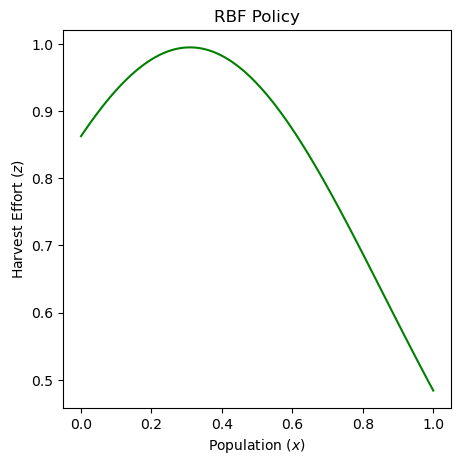

In [16]:
nRBFs = 2
RBF_params = [0.2, 1.1, 0.41, 0.34,0.7, 0.59]
x_range = [0, 1]
x_label = 'Population ($x$)'
y_range = [0,1]
y_label = 'Harvest Effort ($z$)'
plot_RBF_policy(x_range, x_label, y_range, y_label, RBF_params, nRBFs)

This policy does not make much intuitive sense... why should harvesting efforts be _decreased_ when the fish population is _large_? Well, that's because I chose these RBF parameter values randomly.  

Finding a set of optimal RBF parameter values is the next step in this process!

## Harvest strategy objectives 

#### Objective 1: Net present value

The NPV ($O_1$) is calculated as:
$$O_1 = \frac{1}{N} \sum_{i=1}^N\Big( \sum_{t=0}^T \frac{z_{t+1,i}x_{t,i}}{(1+\delta)^t}\Big)$$

where $\delta$ is the discount rate which converts future benefits to present economic value, here $\delta = 0.05$. 

<br />

#### Objective 2: Prey population deficit

$$O_2 = \frac{1}{N} \sum_{i=1}^N\Big( \frac{1}{T} \sum_{t=1}^T \frac{K - x_{t,i}}{K}\Big)$$

where $K$ is the prey population carrying capacity.

<br />

#### Objective 3: Longest duration of consecutive low harvest

$$O_3 = \frac{1}{N} \sum_{i=1}^N(max_T(\phi_{t,i}))$$

where 

$$
\phi_{t,i} = \left\{
	\begin{array}\\
		\phi_{t-1,i} + 1 & \text{if } \ z_t < \text{limit}\\
		0 & \text{otherwise.}
	\end{array}
\right.
$$

<br />

#### Objective 4: Worst harvest instance


$$O_4 = \frac{1}{N} \sum_{i=1}^N(percentile_T(z_{t+1,i}x_{t,i}, 1))$$

<br />

#### Objective #5: Harvest variance


$$O_5 = \frac{1}{N} \sum_{i=1}^N(Var_T(z_{t+1,i}x_{t,i}))$$

<br />

#### Constraint: Avoid collapse of predator population


$$\frac{1}{N} \sum_{i=1}^N(\Psi_{t,i})) = $$

where 

$$
\Psi_{t,i} = \left\{
	\begin{array}\\
		1 & \text{if } \ y_{t,i} < 1\\
		0 & \text{otherwise.}
	\end{array}
\right.
$$

<br />

#### Problem formulation

$$Minimize \ F(z_x) = (-O_1, O_2, O_3, -O_4, O_5)$$


## PyBorg (Lillian)

Brief summary of pyborg.

Mention how it is paired with Platypus as well

## Installation (Lillian)

We should be very detailed here, I noticed that Antonia's pyborg post was not super detailed/clear. 

Also, the ```setup.py``` method she describes is outdated, and prompts a warning.  Instead, we can just mention the dependencies and recommend pip installs for each (i think Platypus and Six are the only non-common libraries)

### Import all libraries
All functions required for this post can be found in the `fish_game_functions.py` file. This code is adapted from [Antonia Hadjimichael's original post](https://waterprogramming.wordpress.com/2021/08/13/introduction-to-pyborg-basic-setup-and-running/) on exploring the Fisheries Game dynamics using PyBorg.

In [1]:
# import all required libraries
from platypus import Problem, Real, Hypervolume, Generator
from pyborg import BorgMOEA
from fish_game_functions import *
from platypus import Problem, Real, Hypervolume, Generator
from pyborg import BorgMOEA
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Label
import random

SyntaxError: invalid syntax (fish_game_functions.py, line 17)

In [ ]:
import ipywidgets as widgets
# Based on Hadjimichael et al 2020
prob_formulation = widgets.Dropdown(options=['5-objective', '3-objective'],
                         description='', value='5-objective', disabled=False)
prob_formulation

### Initializing the problem

Define number of decision variables, constraints, and specify problem formulation (3- or 5-objective)

In [ ]:
from fish_game_functions import *
import pyborg
from platypus import (Problem, Real, Hypervolume)
from pyborg import BorgMOEA
# Set the number of decision variables, constraints and performance objectives
nVars = 6   # Define number of decision variables
nObjs = 5
if prob_formulation == '5-objective':
    nObjs = 5
elif prob_formulation == '3-objective':
    nObjs = 3
nCnstr = 1      # Define number of decision constraints

# Define the upper and lower bounds of the performance objectives
objs_lower_bounds = [-6000, 0, 0, -250, 0]
objs_upper_bounds = [0, 1, 100, 0, 32000]

### Initialize the optimization
The user has the option to set their preferred NFE and intial population size<br>
**Need to include explanations for abbreviations used for the objectives**

In [ ]:
# initialize the optimization
init_list = ['Initial NFE: ', 'Initial population size: ']
init_labels = [Label(i) for i in init_list]

init_nfe = widgets.IntText(value=100, description='Any', disabled=False)
init_pop_size = widgets.IntText(value=100, description='Any', disabled=False)

list_of_inits = [init_nfe, init_pop_size]

HBox([VBox(init_labels), VBox(list_of_inits)])
box_layout_inits = widgets.Layout(display='flex', flex_flow = 'row', align_items ='center', justify_content = 'center')

init_widget = HBox([VBox(init_labels), VBox(list_of_inits)])
box_layout_inits = widgets.Layout(display='flex', flex_flow = 'row', align_items ='center', justify_content = 'center')
init_widget

The objectives scores arn't very good, but that is because the number of function evaluations is so low. In order to get a better set of solutions, we need to run the MOEA for many function evaluations.  

The next section demonstrates the change in objective performance with respect to the number of function evaluations.


### Begin the optimization
Here, we also time the optimization to get a general estimate on the time the full hypervolume analysis will require.

In [ ]:
# begin timing the Borg run
borg_start_time = time.time()

algorithm = fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size=int(init_pop_size))
algorithm.run(int(init_nfe))

# end timing and print optimization time 
borg_end_time = time.time()

borg_total_time = borg_end_time - borg_start_time

print(f"borg_total_time={borg_total_time}s")

### Interactively select objectives to plot
The user can select the objectives that they wish to plot.

In [ ]:
objs_list = ['Objective 1', 'Objective 2', 'Objective 3']

obj1 = widgets.Dropdown(options=['Mean NPV', 'Mean prey deficit', 'Mean WCLH', 
                                 'Mean 1% harvest', 'Mean harvest variance'],
                         description='', value='Mean NPV', disabled=False)
obj2 = widgets.Dropdown(options=['Mean NPV', 'Mean prey deficit', 'Mean WCLH', 
                                 'Mean 1% harvest', 'Mean harvest variance'],
                         description='', value='Mean prey deficit', disabled=False)

obj3 = widgets.Dropdown(options=['Mean NPV', 'Mean prey deficit', 'Mean WCLH', 
                                 'Mean 1% harvest', 'Mean harvest variance'],
                         description='', value='Mean WCLH', disabled=False)

list_of_objs = [Label(i) for i in objs_list]
list_of_dropdowns = [obj1, obj2, obj3]

tradeoff_widget = HBox([VBox(list_of_objs), VBox(list_of_dropdowns)])
box_layout_objs = widgets.Layout(display='flex', flex_flow = 'row', align_items ='center', justify_content = 'center')
tradeoff_widget

### Plot the tradeoff surface
Here, we plot a 3-dimensional plot showing the tradeoff between a select number of objectives. If you have selected the 5-objective problem formulation, you can select the three objectives you would like to analyze the tradeoff surface for.

In [ ]:
# Plot objective tradeoff surface
fig_objs = plt.figure(figsize=(8,8))
ax_objs = fig_objs.add_subplot(111, projection='3d')

objs_indices = []
objs_labels = []
objs_min = []

if nObjs == 5:
    objs_indices = [select_objective(obj1.value)[0], select_objective(obj2.value)[0], select_objective(obj2.value)[0]]
    obj_labels = [obj1.value, obj2.value, obj3.value]
    obj_min = [select_objective(obj1.value)[1], select_objective(obj2.value)[1], select_objective(obj2.value)[1]]
else:
    objs_indices = [0,1,2]
    obj_labels = ['Mean NPV', 'Mean prey deficit', 'Mean WCLH']
    obj_min = [-6000, 0, 0]

plot_3d_tradeoff(algorithm, ax_objs, objs_indices, obj_labels, obj_min)

### MOEA Diagnostics

Explain why to do diagnostic tests.

Reed group Alum Prof. [Joe Kasprzyk wrote a post describing three common MOEA diagnostic metrics](https://waterprogramming.wordpress.com/2013/06/25/moea-performance-metrics/): generational distance, epsilon indicator, and hypervolume. 

#### Hypervolume

The hypervolume is a measure of the multi-dimensional volume _dominated_ by the approximated pareto front. As the pareto front advances toward the "_ideal_" solution, this value approaches 1. 

The efficiency of an MOEA in optimizing a solution can be considered by measuring the hypervolume with respect to the number of function evaluations. This allows the user to understand how quickly the MOEA is converging to a good set of solutions, and how many function evaluations are needed to achieve a good set of solutions.


### Setup the widget
Will need to hide this from the broader user interface

In [ ]:
hvol_list = ['Max number of NFEs: ', 'Step size: ']
maxevals = widgets.IntText(value=200, description='Any', disabled=False)
frequency = widgets.IntText(value=100, description='Any', disabled=False)

param_labels = [Label(i) for i in hvol_list]
list_of_dropdowns = [maxevals, frequency]

hvol_widget = HBox([VBox(param_labels), VBox(list_of_dropdowns)])
box_layout_hvol = widgets.Layout(display='flex', flex_flow = 'row', align_items ='center', justify_content = 'center')
hvol_widget

### Plotting the hypervolume
Here, we make a basic plot of hypervolume vs NFE to show how the problem converges

fig_hvol = plt.figure(figsize=(8,12))
ax_hvol = fig_hvol.add_subplot()

plot_hvol(algorithm, maxevals, frequency, objs_lower_bounds, objs_upper_bounds, ax_hvol)

plt.title('PyBorg Runtime (Hypervolume)')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.show()

### Perform random seed analysis
We test out different initial population sizes. <br>
Performed to show if pyBorg's performance is sensitive to the size of its initial population.

In [ ]:
pop_size_list = [100, 200, 400, 800, 1000]

fig_rand_seed = plt.figure(figsize=(8,12))
ax_rand_seed = fig_rand_seed.add_subplot()

for p in range(len(pop_size_list)):
    fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size_list[p])
    algorithm = fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size=int(init_pop_size))
    algorithm.run(int(init_nfe))
    
    plot_hvol(maxevals, frequency, objs_lower_bounds, objs_upper_bounds, 
              ax_rand_seed, pop_size=pop_size_list[p])

plt.title('PyBorg Random Seed Analysis')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.legend()
plt.show()